# Engineering Predictive Alpha Factors

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
DATA_STORE = Path('..', 'data', 'stock_prices.h5')

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['us_stocks']
            .loc[idx[:, '2007':'2016'],
                 ['open', 'high', 'low', 'close', 'volume']]
            .dropna()
            .sort_index())

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6951874 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    6951874 non-null  float64
 1   high    6951874 non-null  float64
 2   low     6951874 non-null  float64
 3   close   6951874 non-null  float64
 4   volume  6951874 non-null  float64
dtypes: float64(5)
memory usage: 291.8+ MB


In [7]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 3,186 | # Dates: 2,586


## Select 500 most-traded stocks

In [8]:
dv = data.close.mul(data.volume)

In [9]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

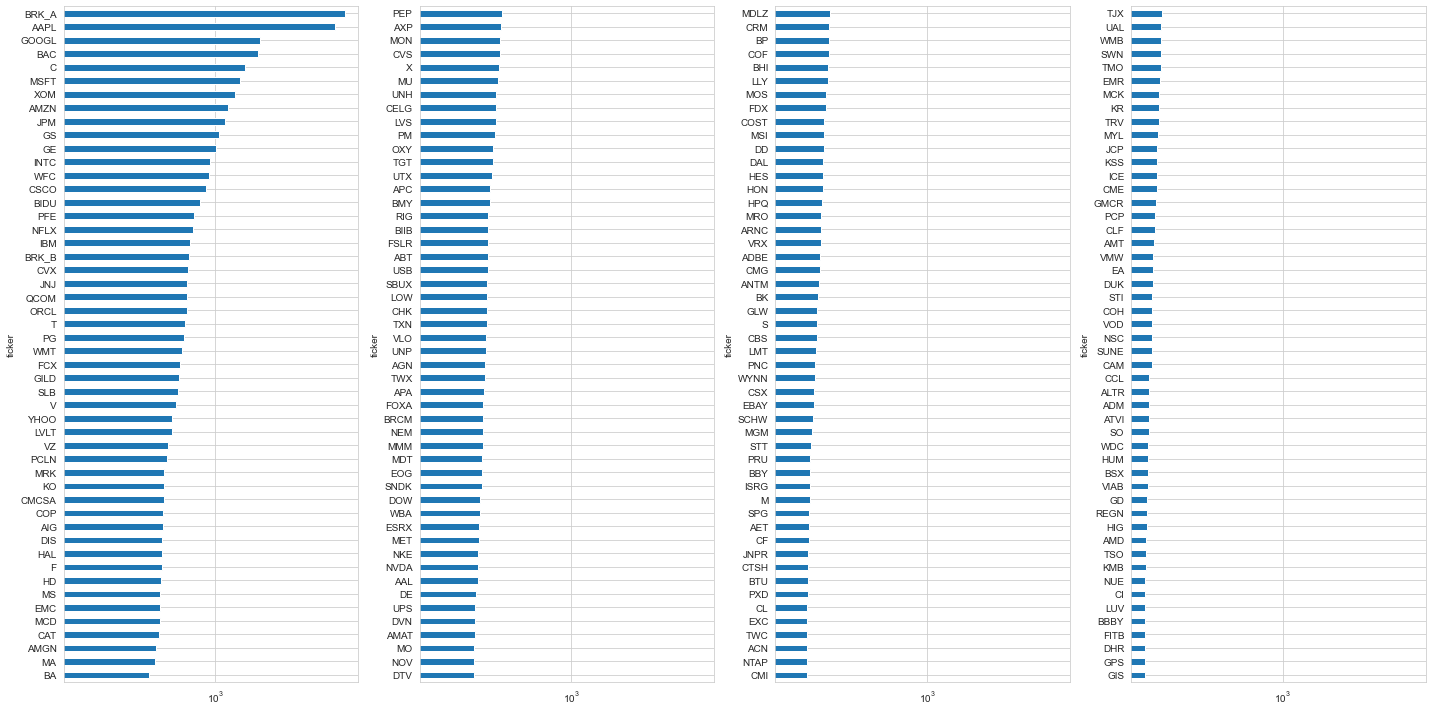

In [10]:
top200 = (data.close
          .mul(data.volume)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .div(1e6)
          .nlargest(200))
cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200.iloc[cutoffs[i-1]:cutoffs[i]
                ].sort_values().plot.barh(logx=True, ax=axes[i-1])
fig.tight_layout()

In [11]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [12]:
len(to_drop)

2686

In [13]:
data = data.drop(to_drop, level='ticker')

In [14]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1248458 entries, ('A', Timestamp('2007-01-03 00:00:00')) to ('ZMH', Timestamp('2015-06-26 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1248458 non-null  float64
 1   high    1248458 non-null  float64
 2   low     1248458 non-null  float64
 3   close   1248458 non-null  float64
 4   volume  1248458 non-null  float64
dtypes: float64(5)
memory usage: 52.4+ MB


In [15]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,518


### Remove outlier observations based on daily returns

In [16]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

Dropped 502


In [17]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 500 | # Dates: 2,517


### Sample price data for illustration

In [18]:
ticker = 'AAPL'
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True)

In [19]:
price_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2007-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2517 non-null   float64
 1   high    2517 non-null   float64
 2   low     2517 non-null   float64
 3   close   2517 non-null   float64
 4   volume  2517 non-null   float64
dtypes: float64(5)
memory usage: 118.0 KB


In [20]:
price_sample.to_hdf('../data/us_stocks.h5', 'data/sample')

## Compute returns

Group data by ticker

In [21]:
by_ticker = data.groupby(level='ticker')

### Historical returns

In [22]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

In [23]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t)

### Forward returns

In [24]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1)
data = data.dropna(subset=['ret_fwd'])

## Persist results

In [25]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1247456 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     1247456 non-null  float64
 1   high     1247456 non-null  float64
 2   low      1247456 non-null  float64
 3   close    1247456 non-null  float64
 4   volume   1247456 non-null  float64
 5   ret_01   1246956 non-null  float64
 6   ret_03   1245956 non-null  float64
 7   ret_05   1244956 non-null  float64
 8   ret_10   1242456 non-null  float64
 9   ret_21   1236956 non-null  float64
 10  ret_42   1226456 non-null  float64
 11  ret_63   1215956 non-null  float64
 12  ret_126  1184456 non-null  float64
 13  ret_252  1121456 non-null  float64
 14  ret_fwd  1247456 non-null  float64
dtypes: float64(15)
memory usage: 147.6+ MB


## Bollinger Bands

In [26]:
df = price_sample.loc['2012', ['close']]

In [27]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

In [28]:
bb_bands = ['upper', 'middle', 'lower']

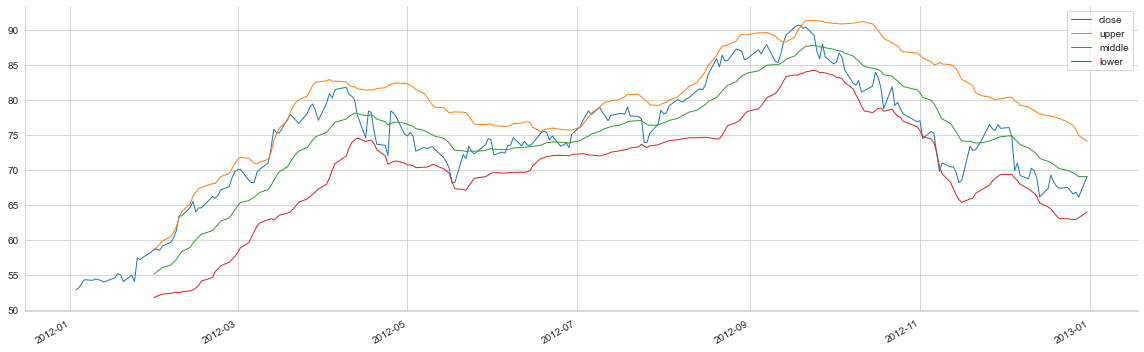

In [29]:
df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Normalized squeeze & mean reversion indicators

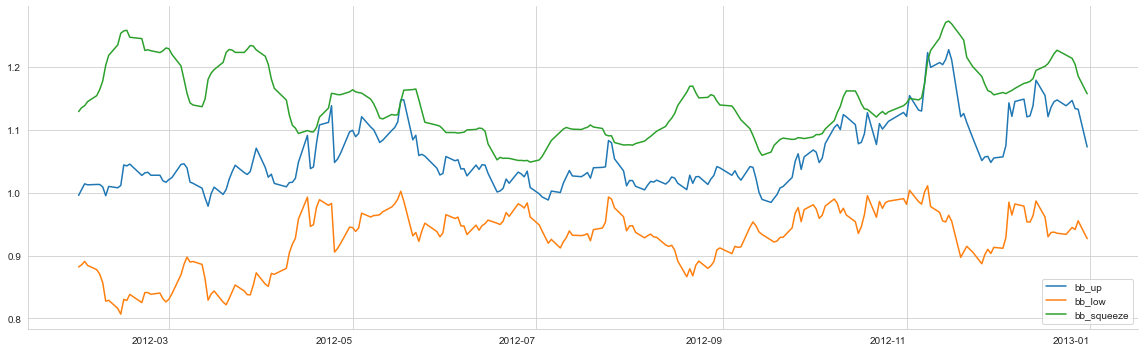

In [30]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [31]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [32]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

#### Visualize Distribution

In [33]:
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']

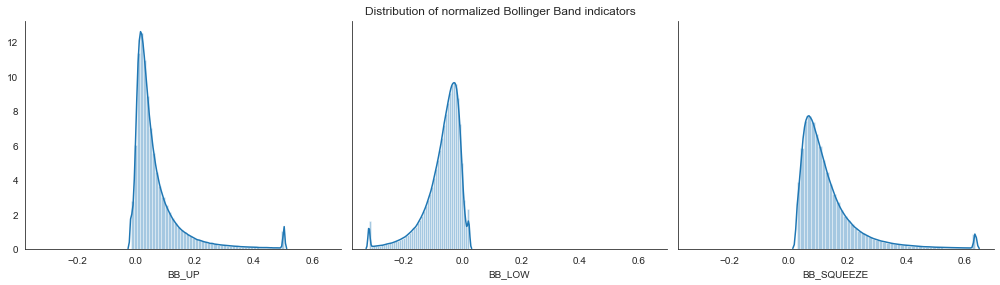

In [34]:
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

#### Plot outlier price series

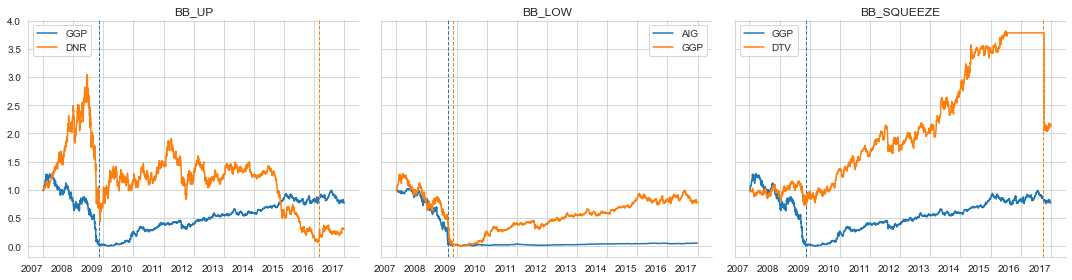

In [35]:
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    ticker, date = data[indicator].nlargest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    ticker, date = data[indicator].nsmallest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('ticker', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)    
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout();

### Hilbert Transform - Instantaneous Trendline

The Hilbert Transform generates inphase and quadrature components of a de-trended real-valued signal like a price series to analyze variations of the instantaneous phase and amplitude.

HTTrendline returns the price series value after the Dominant Cycle of the analytic signal as generated by the Hilbert Transform has been removed. The Dominant Cycle can be thought of as being the "most likely" period (in the range of 10 to 40) of a sine function of the Price Series. See [here](http://www2.wealth-lab.com/WL5Wiki/HTTrendLine.ashx) for additional detail on computation.

In [36]:
df = price_sample.loc['2012', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)

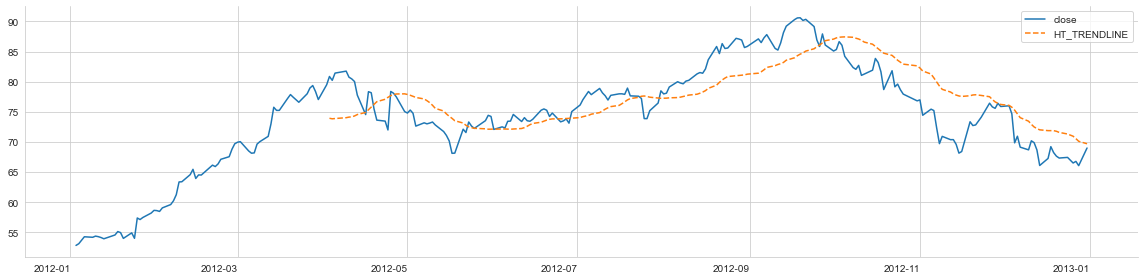

In [37]:
ax = df.plot(figsize=(16, 4), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Compute Hilbert-based normalized indicator

In [38]:
data['HT'] = (data
              .groupby(level='ticker', group_keys=False)
              .close
              .apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))

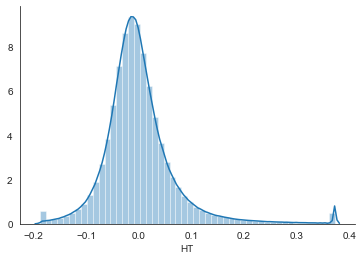

In [39]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

### Parabolic SAR

The Parabolic SAR aims to identify trend reversals. It is a trend-following (lagging) indicator that can be used to set a trailing stop loss or determine entry or exit points. It is usually represented in a price chart as a set of dots near the price bars. Generally, when these dots are above the price, it signals a downward trend, and an upward trend if the dots are below the price. The change in the direction of the dots can be interpreted as a  trade signal. However, the indicator is not as reliable in a flat or range-bound markt. It is compute as follows:

$$\text{SAR}_t=\text{SAR}_{t-1} + \alpha (\text{EP}-\text{SAR}_{t-1})$$

EP (the extreme point) is a record kept during each trend that represents the highest value reached by the price during the current uptrend – or lowest value during a downtrend. During each period, if a new maximum (or minimum) is observed, the EP is updated with that value.

The α value represents the acceleration factor and is typically set initially to a value of 0.02. This factor increases by α each time a new EP is recorded. The rate will then quicken to a point where the SAR converges towards the price. To prevent it from getting too large, a maximum value for the acceleration factor is normally set to 0.20.

For additional detail, see [wikipedia](https://en.wikipedia.org/wiki/Parabolic_SAR); there is also an [extended SAR](http://www.tadoc.org/indicator/SAR.htm).

In [40]:
df = price_sample.loc['2012', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, 
                      acceleration=0.02, # common value
                      maximum=0.2)       

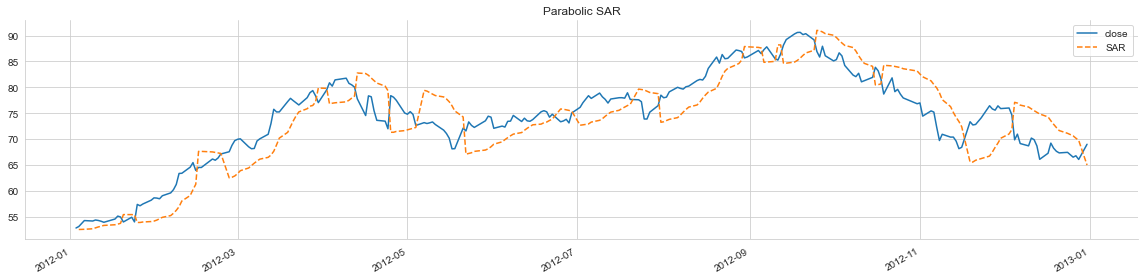

In [41]:
ax = df[['close', 'SAR']].plot(figsize=(16, 4), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Normalized SAR indicator

In [42]:
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, 
                    x.low,
                    acceleration=acceleration,
                    maximum=maximum)
    return sar/x.close - 1

In [43]:
data['SAR'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_sar_indicator))

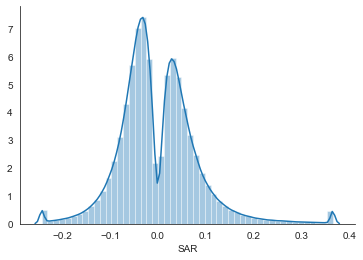

In [44]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

## Momentum Indicators

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

#### Plus/Minus Directional Movement (PLUS_DM/MINUS_DM)

For a price series $P_t$ with daily highs $P^H_t$ and daily lows $P^L_t$, the directional movement tracks the absolute size of price moves over a timeperiod T as follows:

$$\begin{align*}
\text{Up}_t & =P^H_t-P^H_{t-T} \\
\text{Down}_t & = P^L_{t-T} - P^L_t\\
\text{PLUS_DM}_t & = 
\begin{cases}
\text{Up}_t & \text{if Up}_t > \text{Down}_t \text{and Up}_t > 0 \\
0 & \text{otherwise}
\end{cases} \\
\text{MINUS_DM}_t & = 
\begin{cases}
\text{Down}_t & \text{if Down}_t > \text{Up}_t \text{and Down}_t < 0 \\
0 & \text{otherwise}
\end{cases}
\end{align*}$$

In [45]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [46]:
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

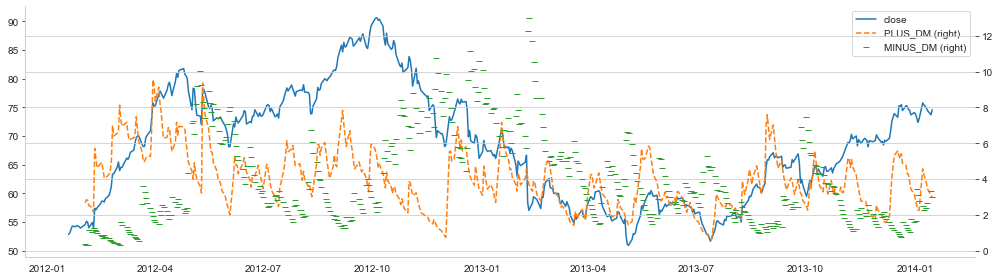

In [47]:
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=[
                                                   'PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'],
                                              rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### Plus/Minus Directional Index (PLUS_DI/MINUS_DI)

`PLUS_DI` and `MINUS_DI` are the simple moving average of `PLUS_DM` and `MINUS_DM`, respectively, each divided by the average true range (`ATR`, see below).

The smoothed moving average is calculated over the number of periods selected, and the average true range is a smoothed average of the true ranges.

In [48]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [49]:
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)

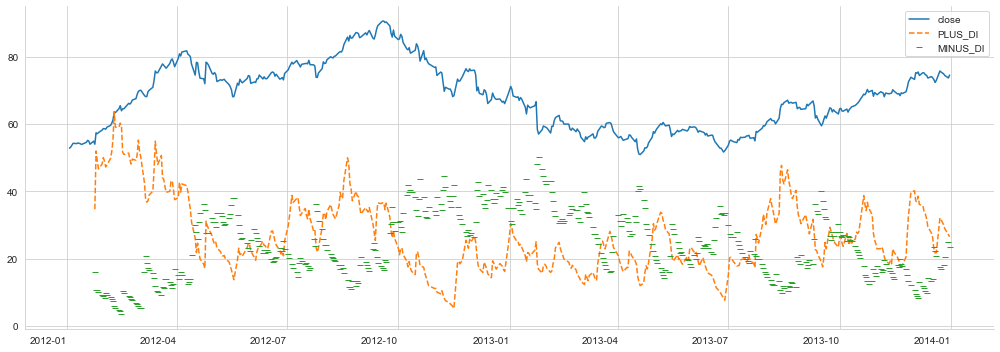

In [50]:
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(14, 5), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Average directional movement index (ADX)

The ADX is the (simple) moving average of the absolute value of the difference between PLUS_DI and MINUS_DI, divided by their sum:

$$
\text{ADX}=100\times\text{SMA}(N)_t\left|\frac{\text{PLUS_DI}_t-\text{MINUS_DI}_t}{\text{PLUS_DI}_t+\text{MINUS_DI}_t}\right|
$$

|ADX Value|	Trend Strength|
|:---|:---|
|0-25 |	Absent or Weak Trend|
|25-50 |	Strong Trend|
|50-75 |	Very Strong Trend|
|75-100 |	Extremely Strong Trend|

In [51]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [52]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

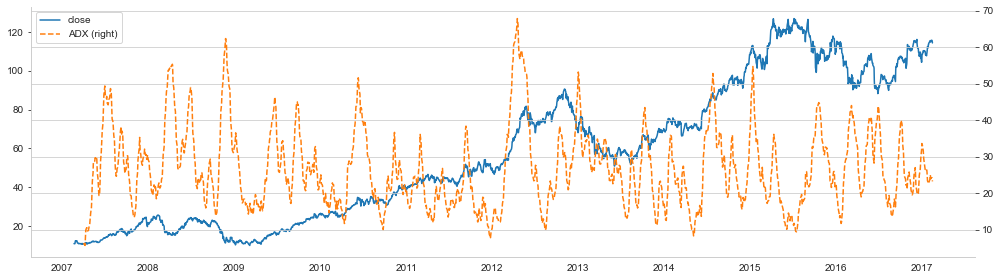

In [53]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [54]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [55]:
data['ADX'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_adx))

#### Visualize distribution

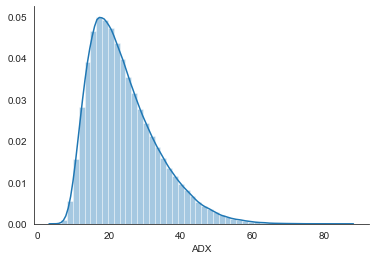

In [56]:
with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

#### Average Directional Movement Index Rating

Averages the current ADX and the ADX T periods ago.

In [57]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [58]:
df['ADXR'] = talib.ADXR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

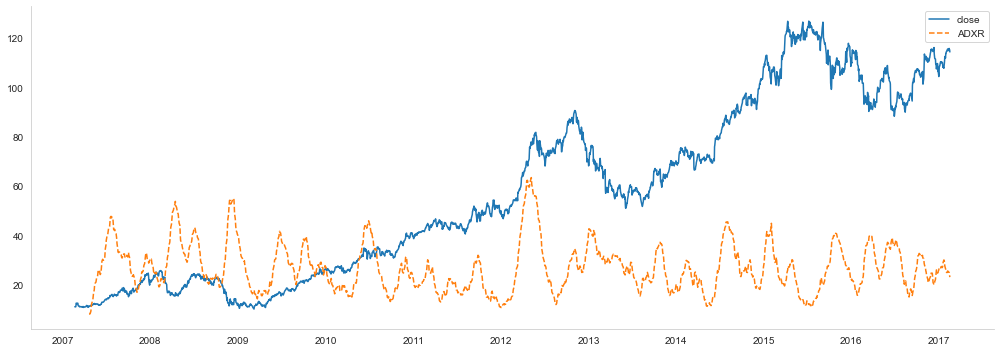

In [59]:
ax = df[['close', 'ADXR']].plot(figsize=(14, 5),
                                secondary_y='ADX',
                                style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [60]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [61]:
data['ADXR'] = (data.groupby(level='ticker', group_keys=False)
                .apply(compute_adxr))

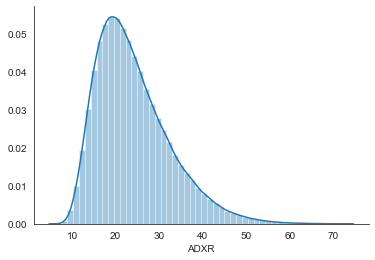

In [62]:
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

In [63]:
df = price_sample.loc[:, ['close']]

In [64]:
df['APO'] = talib.APO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

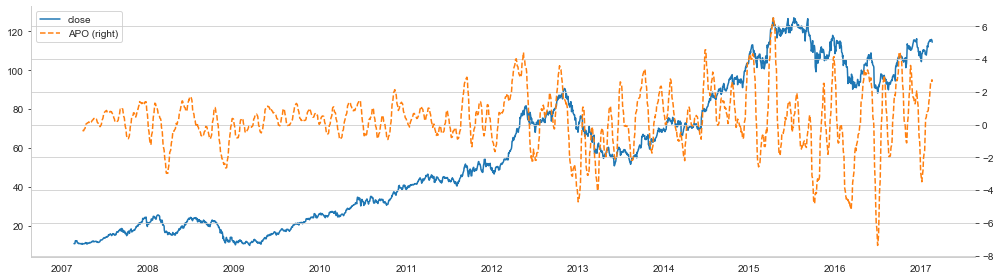

In [65]:
ax = df.plot(figsize=(14,4), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

In [66]:
df = price_sample.loc[:, ['close']]

In [67]:
df['PPO'] = talib.PPO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

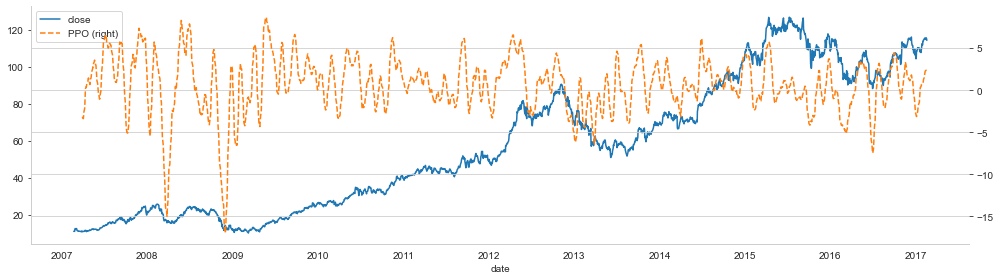

In [68]:
ax = df.plot(figsize=(14,4), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [69]:
data['PPO'] = (data.groupby(level='ticker')
               .close
               .apply(talib.PPO, 
                      fastperiod=12, 
                      slowperiod=26, 
                      matype=1))

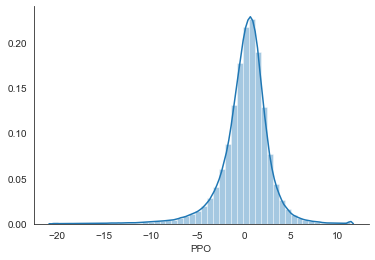

In [70]:
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q),
                               upper=data.PPO.quantile(1-q)))
    sns.despine()

### Aroon Oscillator

#### Aroon Up/Down Indicator

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

In [71]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [72]:
aroonup, aroondwn = talib.AROON(high=df.high,
                                low=df.low,
                                timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn

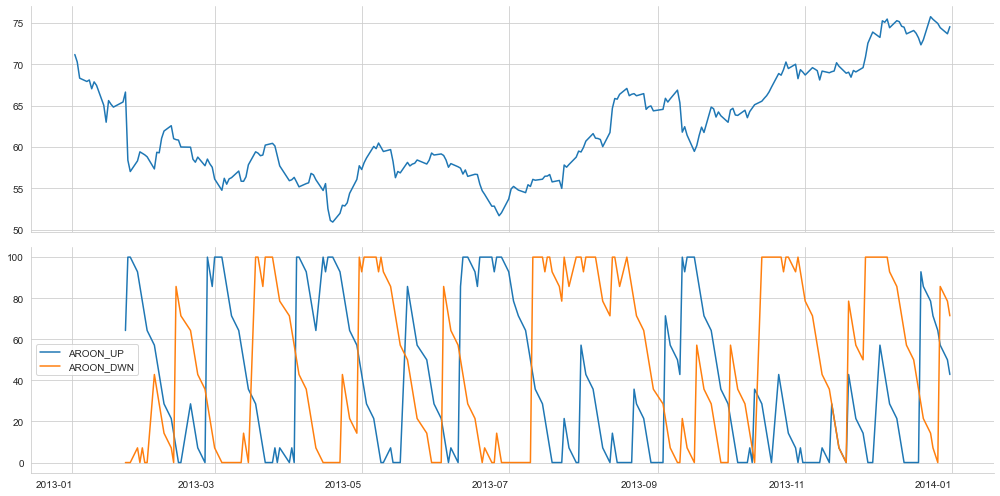

In [73]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

#### Aroon Oscillator

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

In [74]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [75]:
df['AROONOSC'] = talib.AROONOSC(high=df.high,
                                low=df.low,
                                timeperiod=14)

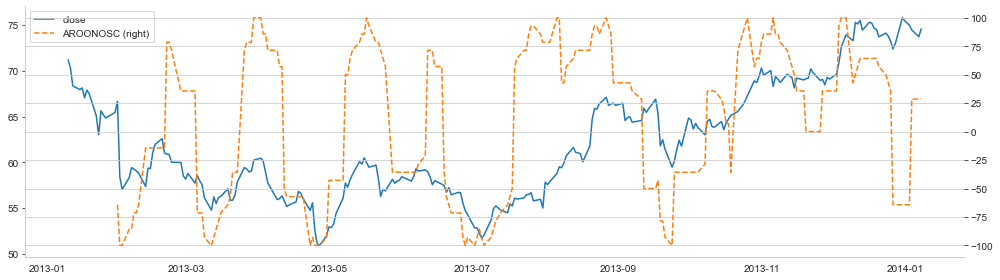

In [76]:
ax = df[['close', 'AROONOSC']].plot(figsize=(14,4), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [77]:
data['AARONOSC'] = (data.groupby('ticker',
                                 group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high,
                                                    low=x.low,
                                                    timeperiod=14)))

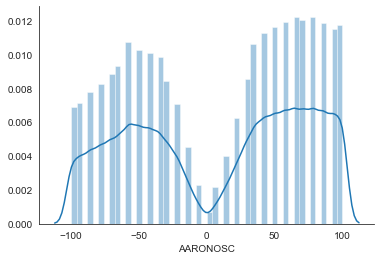

In [78]:
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [79]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]

In [80]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

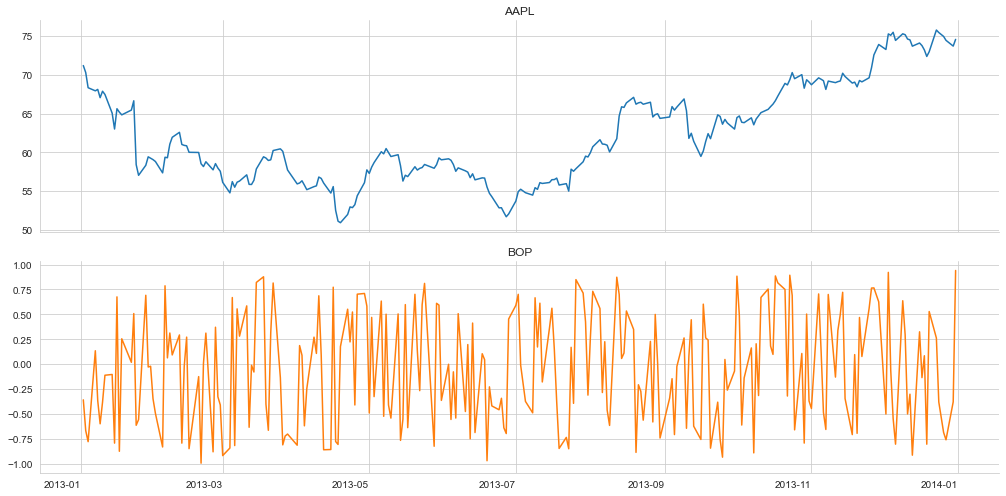

In [81]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

In [82]:
by_ticker = data.groupby('ticker', group_keys=False)

In [83]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

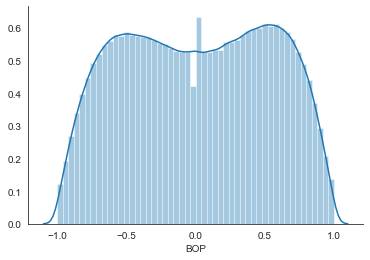

In [84]:
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q),
                               upper=data.BOP.quantile(1-q)))
    sns.despine()

### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [85]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [86]:
df['CCI'] = talib.CCI(high=df.high,
                      low=df.low,
                      close=df.close,
                      timeperiod=14)

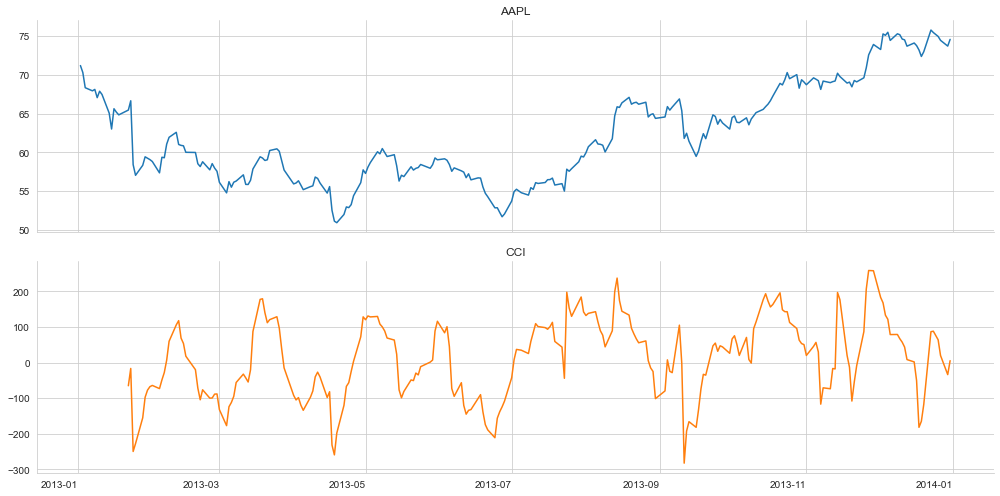

In [87]:
axes = df[['close', 'CCI']].plot(figsize=(14, 7), 
                                 rot=0, 
                                 subplots=True, 
                                 title=['AAPL', 'CCI'], 
                                 legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [88]:
data['CCI'] = (by_ticker
               .apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x.close,
                                          timeperiod=14)))

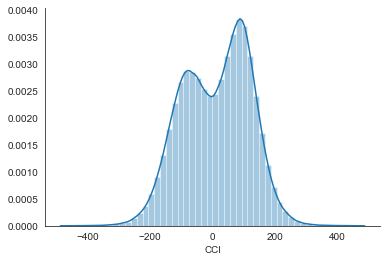

In [89]:
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [90]:
df = price_sample.loc['2013', ['close']]

In [91]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

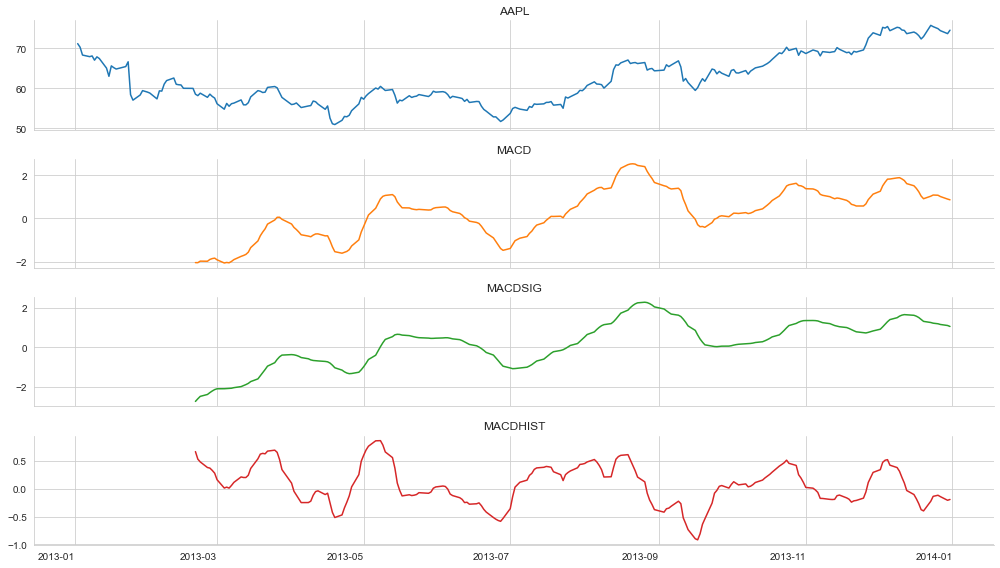

In [92]:
axes = df.plot(figsize=(14, 8),
               rot=0,
               subplots=True,
               title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [93]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [94]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_macd)))

In [95]:
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']

In [96]:
data[macd_indicators].corr()

,MACD,MACD_SIGNAL,MACD_HIST
MACD,1.000000,0.953842,0.355116
MACD_SIGNAL,0.953842,1.000000,0.057988
MACD_HIST,0.355116,0.057988,1.000000


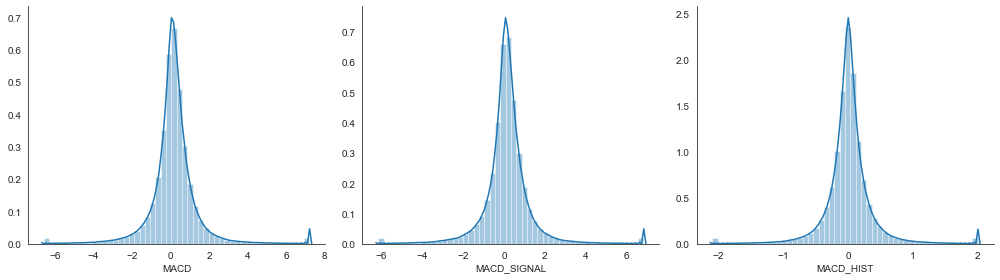

In [97]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

In [98]:
df = price_sample.loc['2013', ['close']]

In [99]:
df['CMO'] = talib.CMO(df.close, timeperiod=14)

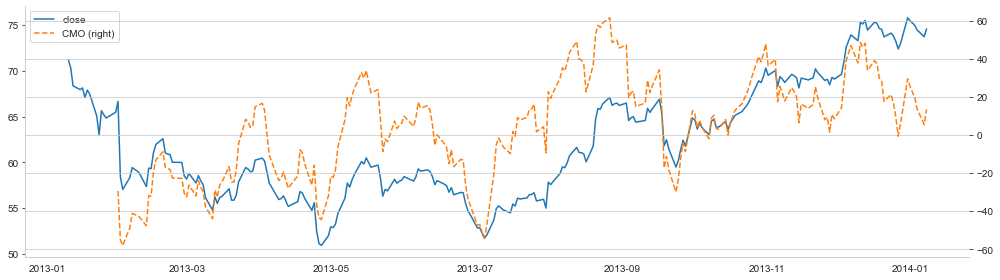

In [100]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

Not included due to high correlation with PPO.

In [101]:
# data['CMO'] = (by_ticker
#                .apply(lambda x: talib.CMO(x.close,
#                                           timeperiod=14)))

In [102]:
# sns.distplot(data.CMO);

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [103]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [104]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

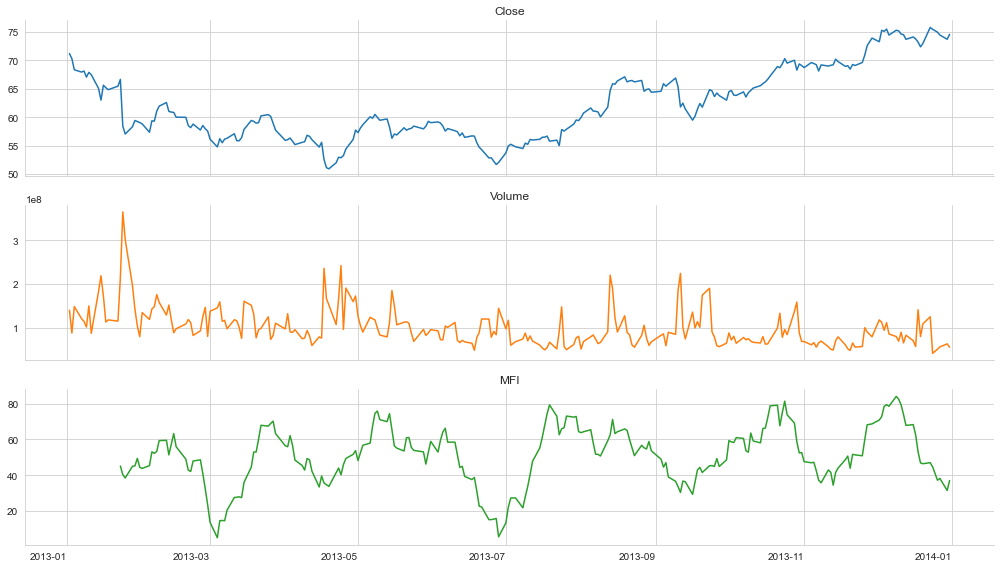

In [105]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [106]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

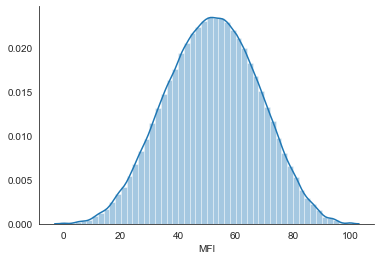

In [107]:
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [108]:
df = price_sample.loc['2013', ['close']]

In [109]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

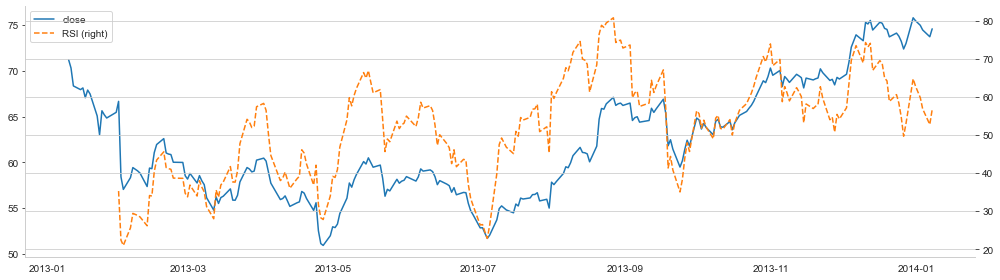

In [110]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [111]:
data['RSI'] = (by_ticker
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

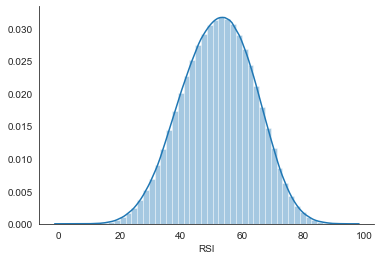

In [112]:
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [113]:
df = price_sample.loc['2013', ['close']]

In [114]:
fastk, fastd = talib.STOCHRSI(df.close,
                              timeperiod=14, 
                              fastk_period=14, 
                              fastd_period=3, 
                              fastd_matype=0)
df['fastk'] = fastk
df['fastd'] = fastd

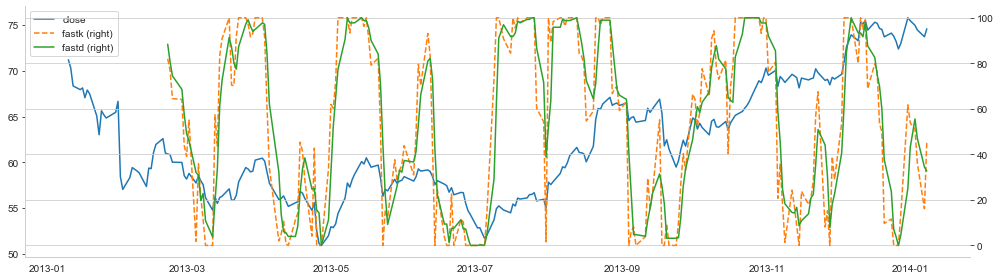

In [115]:
ax = df.plot(figsize=(14, 4),
             rot=0,
             secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [116]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close,
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

In [117]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [118]:
slowk, slowd = talib.STOCH(df.high,
                           df.low,
                           df.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
df['STOCH'] = slowd / slowk

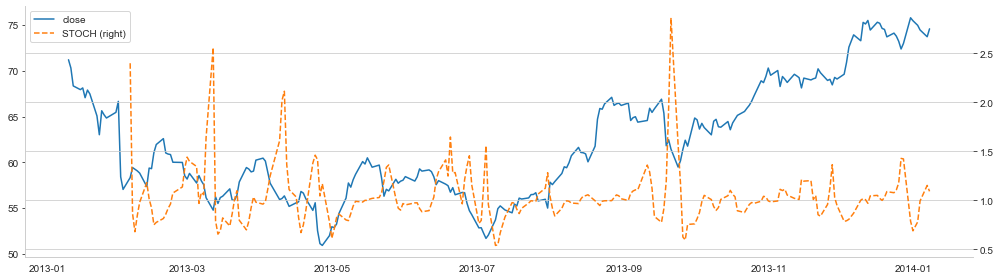

In [119]:
ax = df[['close', 'STOCH']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [120]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close,
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return slowd/slowk-1

In [121]:
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan

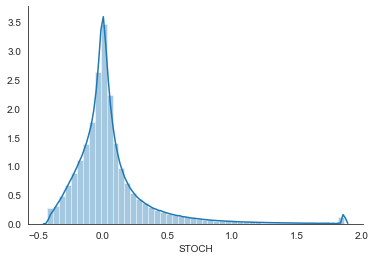

In [122]:
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q),
                             upper=data.STOCH.quantile(1-q)));

    sns.despine();

### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [123]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [124]:
df['ULTOSC'] = talib.ULTOSC(df.high,
                            df.low,
                            df.close,
                            timeperiod1=7,
                            timeperiod2=14,
                            timeperiod3=28)

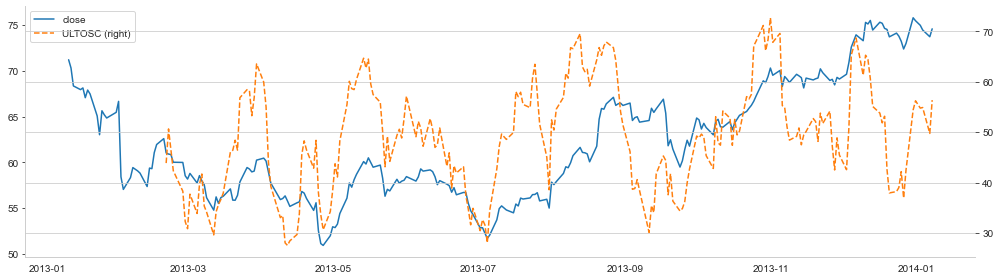

In [125]:
ax = df[['close', 'ULTOSC']].plot(figsize=(14, 4),
                                  rot=0,
                                  secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [126]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high,
                        x.low,
                        x.close,
                        timeperiod1=timeperiod1,
                        timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)

In [127]:
data['ULTOSC'] = by_ticker.apply(compute_ultosc)

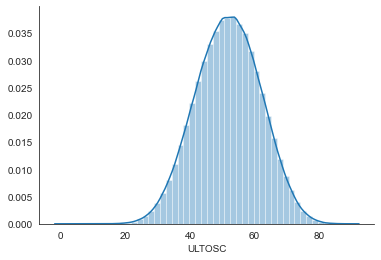

In [128]:
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [129]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [130]:
df['WILLR'] = talib.WILLR(df.high,
                          df.low,
                          df.close,
                          timeperiod=14)

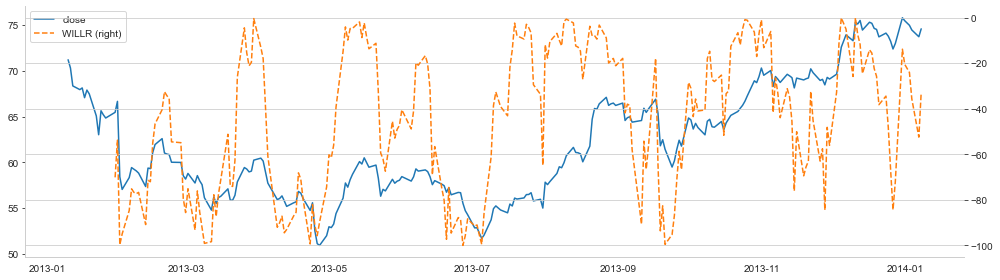

In [131]:
ax = df[['close', 'WILLR']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [132]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))

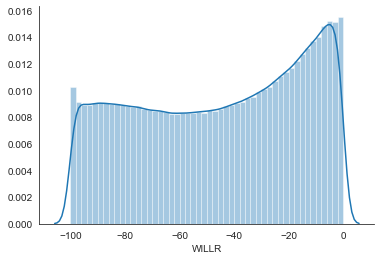

In [133]:
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [134]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [135]:
df['AD'] = talib.AD(df.high,
                    df.low,
                    df.close,
                    df.volume)

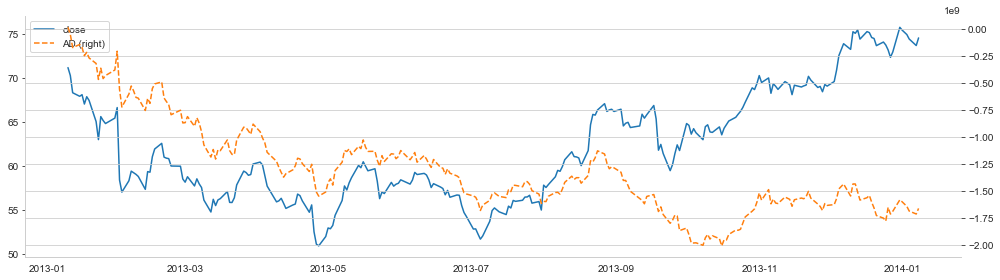

In [136]:
ax = df[['close', 'AD']].plot(figsize=(14, 4),
                              rot=0,
                              secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

Divide by average volume to normalize across assets.

In [137]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

In [138]:
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    1.247456e+06
mean     3.734982e+01
std      4.770034e+01
min     -1.987525e+02
25%      4.598627e+00
50%      3.092931e+01
75%      6.560986e+01
max      4.825112e+02
Name: AD, dtype: float64

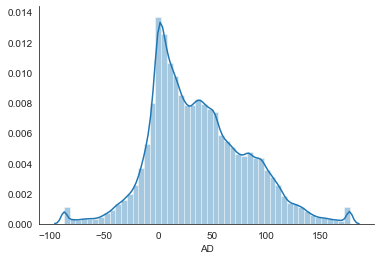

In [139]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q),
                     upper=AD.quantile(1-q)));

    sns.despine();

### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

In [140]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [141]:
df['ADOSC'] = talib.ADOSC(df.high,
                          df.low,
                          df.close,
                          df.volume,
                          fastperiod=3,
                          slowperiod=10)

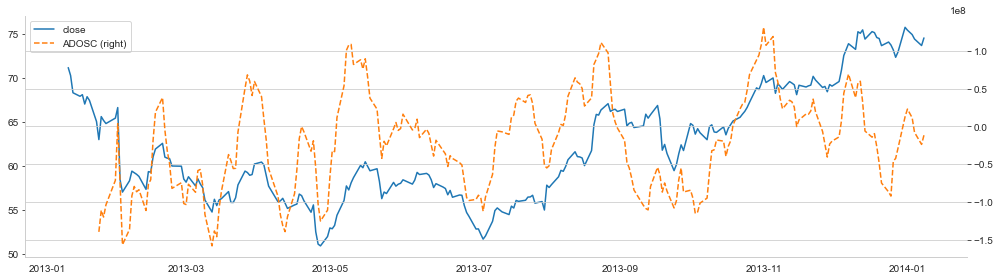

In [142]:
ax = df[['close', 'ADOSC']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [143]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high,
                                                      x.low,
                                                      x.close,
                                                      x.volume,
                                                      fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())

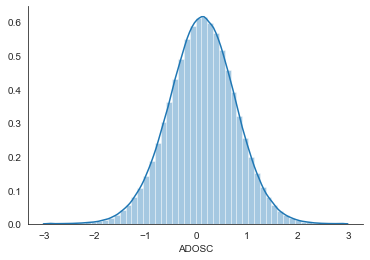

In [144]:
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q),
                             upper=data.ADOSC.quantile(1-q)))
    sns.despine();

### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [145]:
df = price_sample.loc['2013', ['close', 'volume']]

In [146]:
df['OBV'] = talib.OBV(df.close,
                      df.volume)

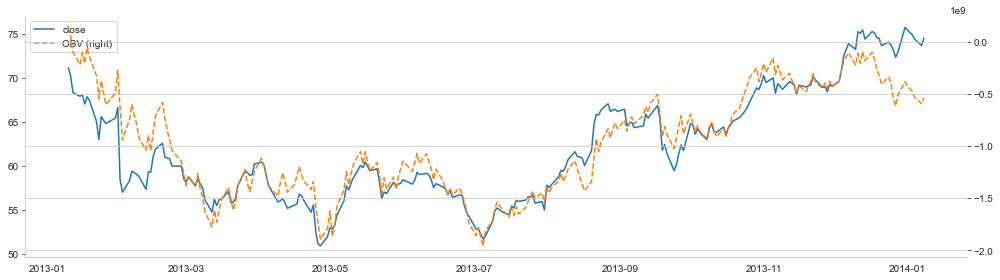

In [147]:
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [148]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close,
                                                  x.volume)/x.expanding().volume.mean())

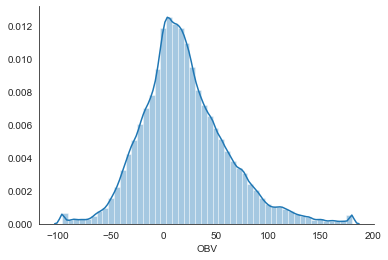

In [149]:
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q),
                               upper=data.OBV.quantile(1-q)))
    sns.despine()

## Volatility Indicators

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [150]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [151]:
df['ATR'] = talib.ATR(df.high,
                      df.low,
                      df.close,
                      timeperiod=14)

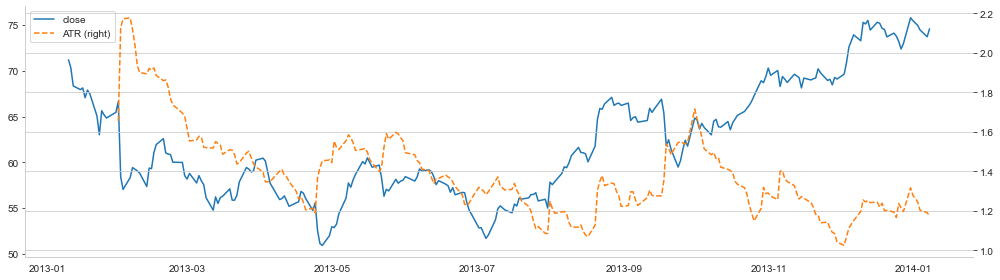

In [152]:
ax = df[['close', 'ATR']].plot(figsize=(14, 4),
                          rot=0,
                          secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### Compute normalized version of ATR using rolling mean of price

In [153]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high,
                                                  x.low,
                                                  x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())

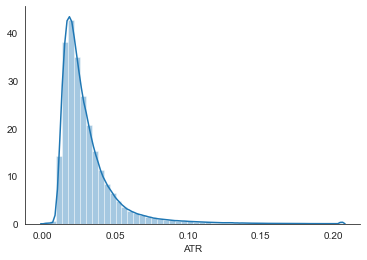

In [154]:
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [155]:
df = price_sample.loc['2013', ['high', 'low', 'close']]

In [156]:
df['NATR'] = talib.NATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

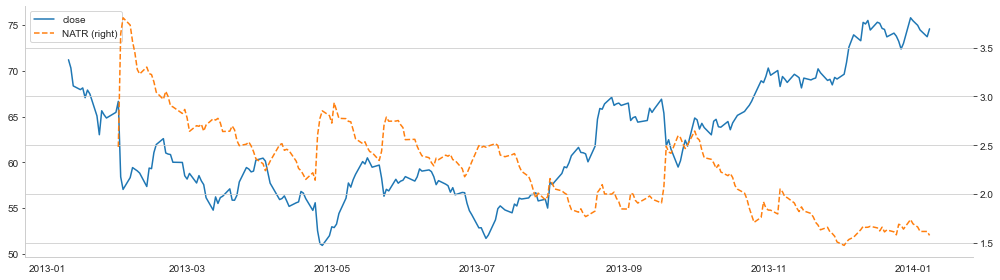

In [157]:
ax = df[['close', 'NATR']].plot(figsize=(14, 4),
                           rot=0,
                           secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

## Rolling Factor Betas

In [160]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2005)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [161]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [162]:
t = 1
ret = f'ret_{t:02}'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

21
63
252


## Persist results

In [163]:
data = (data
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
        .replace((np.inf, -np.inf), np.nan))

In [164]:
data.dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1247456 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1246956 non-null  float64
 1   ret_03       1245956 non-null  float64
 2   ret_05       1244956 non-null  float64
 3   ret_10       1242456 non-null  float64
 4   ret_21       1236956 non-null  float64
 5   ret_42       1226456 non-null  float64
 6   ret_63       1215956 non-null  float64
 7   ret_126      1184456 non-null  float64
 8   ret_252      1121456 non-null  float64
 9   ret_fwd      1247456 non-null  float64
 10  BB_UP        1237956 non-null  float64
 11  BB_LOW       1237956 non-null  float64
 12  BB_SQUEEZE   1237956 non-null  float64
 13  HT           1215956 non-null  float64
 14  SAR          1246956 non-null  float64
 15  ADX          1233956 non-null  float64
 16  ADXR         12274

In [165]:
with pd.HDFStore('../data/stock_prices.h5') as store:
    store.put('model_data', data)